In [7]:
!pip install cmcrameri
!pip install pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 56.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from cmcrameri import cm 
from matplotlib.colors import LogNorm  
from mpl_toolkits.mplot3d import Axes3D

In [2]:
"""
I changed the code so that for each domain size it gives a dims_nxlen_nylen and an out_nxlen_ny_len file, with nxlen and nylen the size of the domain. The dims file give
the dimensions of nx and ny on rank number 0, to see how the domain is split up. Everything you run the code the thread and core number and runtime or dimensions will be
appended to those files and it will not get overwritten anymore. 
The speedup give the speedup compared to the base configuration of 1 core and 1 thread. 

I also added a part which allows to run on eiger supercomputer, I was curious if there would be differences, and it seems there is!
On eiger running on 2 mpi tasks is faster than on 4 mpi tasks. Maybe we can add a small part in the report about how it changes per supercomputer architecture.

Now the script also writes to either _eiger* files when running on eiger and on no name _nx_ny when running on santis automatically. 
You just have to change the file name of the file you read in to plot.

We can try to change the partitioner so it partitions into different shapes?
"""

'\nI changed the code so that for each domain size it gives a dims_nxlen_nylen and an out_nxlen_ny_len file, with nxlen and nylen the size of the domain. The dims file give\nthe dimensions of nx and ny on rank number 0, to see how the domain is split up. Everything you run the code the thread and core number and runtime or dimensions will be\nappended to those files and it will not get overwritten anymore. \nThe speedup give the speedup compared to the base configuration of 1 core and 1 thread. \n\nI also added a part which allows to run on eiger supercomputer, I was curious if there would be differences, and it seems there is!\nOn eiger running on 2 mpi tasks is faster than on 4 mpi tasks. Maybe we can add a small part in the report about how it changes per supercomputer architecture.\n\nNow the script also writes to either _eiger* files when running on eiger and on no name _nx_ny when running on santis automatically. \nYou just have to change the file name of the file you read in to 

In [3]:
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"
# os.environ["OMP_STACKSIZE"] = "1G"

In [4]:
%%bash
if [[ $(hostname -s) == eiger-* ]]; then
uenv run prgenv-gnu/24.11:v2 --view=default -- make clean
uenv run prgenv-gnu/24.11:v2 --view=default -- make VERSION=kparallel_mpi
else
make clean
make VERSION=kparallel_mpi
fi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/*
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_partitioner.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-kparallel_mpi.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o m_partitioner.o stencil2d-kparallel_mpi.o -o stencil2d-kparallel_mpi.x
cp stencil2d-kparallel_mpi.x stencil2d.x


In [5]:
%%bash 
echo "$(hostname -s)"
if [[ $(hostname -s) == eiger-* ]]; then
    echo "You are on eiger"
fi

nid005209


In [6]:
%%bash

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims.txt

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out_eiger.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims_eiger.txt


for nthreads in $(seq 1 1); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 72 ]; then
    ncores=72
  fi

  # for nnodes in $(seq 1 6); do
  nnodes=1
    echo "Running with $nthreads threads and $nnodes MPI tasks"
    if [[ $(hostname -s) == eiger-* ]]; then
        output=$(uenv run prgenv-gnu/24.11:v2 --view=default -- srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    else    
        output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    fi
    echo $output

    data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
    runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
    
    dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
    nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
    ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
       
    if [[ $(hostname -s) == eiger-* ]]; then
        echo "You are on eiger"
      printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out_eiger.txt
      printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims_eiger.txt
    else
        echo "You are on santis"
      printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out.txt
      printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims.txt
    fi
    echo "baseline runtime = $runtime"
    done
done
done
echo $'baseline runtime =$runtime'

Running with 1 threads and 1 MPI tasks
#threads = 1 # ranks nx ny nz num_iter time nx_rank0 ny_rank0 data = np.array( [ \ [ 128, 128] [ 128, 128] [ 1, 128, 128, 64, 1024, 0.7384414E+00], \ ] )
You are on santis
baseline runtime = 0.7384414E+00


In [7]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

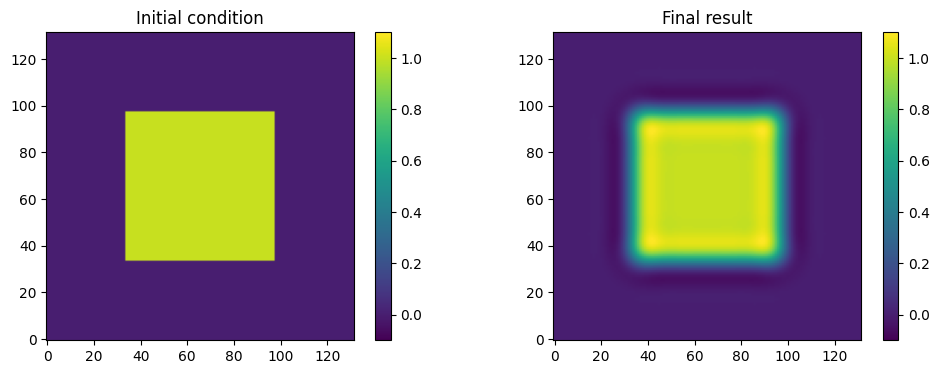

In [8]:
validate_results()

In [9]:
ls

 bash_all_rainette.sh   in_field.dat             out_256_256.txt
 bash_all.sh            Makefile                 out_64_64.txt
 bash_baseline.sh       m_partitioner.F90        out_eiger.txt
 bash_onecpu.sh         m_partitioner.mod        out_field.dat
 dims_1024_1024.txt     m_partitioner.o          out.txt
 dims_128_128.txt       m_utils.F90              perf_wrap.sh*
 dims_128_256.txt       m_utils.mod              plots/
 dims_16_16.txt         m_utils.o                README.md
 dims_256_128.txt      'OPENMP_MPI (1).ipynb'    stencil2d-base.F90
 dims_256_256.txt       OPENMP_MPI_clean.ipynb   stencil2d-kparallel.F90
 dims_64_64.txt         OPENMP_MPI.ipynb         stencil2d-kparallel_mpi.F90
 dims_eiger.txt         out_1024_1024.txt        stencil2d-kparallel_mpi.o
 dims.txt               out_128_128.txt          stencil2d-kparallel_mpi.x*
 experiments/           out_128_256.txt          stencil2d-mpi.F90
 experiments_final/     out_16_16.txt            stencil2d.x*
 experiments_

In [10]:
%%bash
srun -n 1 ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024

 #threads =           72
# ranks nx ny nz num_iter time nx_rank0 ny_rank0
data = np.array( [ \

[  128,  128]

[  128,  128]
[    1,  128,  128,   64,    1024,  0.3455282E+00], \
] )


In [12]:
%%bash
srun -n 1 bash ../perf_wrap.sh ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024

 #threads =           72
# ranks nx ny nz num_iter time nx_rank0 ny_rank0
data = np.array( [ \

[  128,  128]

[  128,  128]
[    1,  128,  128,   64,    1024,  0.2606254E+00], \
] )


12009.43,msec,task-clock,12009429120,100.00,37.831,CPUs utilized
31377505604,,cycles,9417316096,79.52,2.613,GHz
160580934199,,instructions,8647093408,72.11,5.12,insn per cycle
29458692667,,cache-references,8664866240,72.16,2.453,G/sec
98972269,,cache-misses,9330234048,77.55,0.336,of all cache refs
<not supported>,,branches,0,100.00,,
2054458,,branch-misses,8960840032,74.59,,
29584878836,,L1-dcache-loads,9205252448,76.62,2.463,G/sec
96966843,,L1-dcache-load-misses,10018318272,83.63,0.33,of all L1-dcache accesses
69062919,,LLC-loads,8911410624,74.44,5.751,M/sec
45772081,,LLC-load-misses,8449965984,72.13,66.28,of all LL-cache accesses


In [47]:
nx_len=64
ny_len=64

In [48]:
%%bash -s "$nx_len" "$ny_len"
nx_len=$1
ny_len=$2
echo "nx_len = $nx_len, ny_len = $ny_len"

file_name="perf"

out_file="experiments/out_${nx_len}_${ny_len}_${file_name}.txt"
dims_file="experiments/dims_${nx_len}_${ny_len}_${file_name}.txt"

if [[ $(hostname -s) == eiger-* ]]; then
  out_file="experiments/out_eiger_${nx_len}_${ny_len}_${file_name}.txt"
  dims_file="experiments/dims_eiger_${nx_len}_${ny_len}_${file_name}.txt"
fi

if [ ! -f "$out_file" ]; then
  echo "runtimes = [[[0.0]*73 for _ in range(73)]for _ in range(20)]" > "$out_file"
fi

if [ ! -f "$dims_file" ]; then
  echo "dimensions = [[[0.0]*73 for _ in range(73)]for _ in range(20)]" > "$dims_file"
fi
HINT="--hint=nomultithread"
BIND="--cpu-bind=cores"
for iteration in  1; do

    for nthreads in $(seq 5 20); do
        export OMP_NUM_THREADS=$nthreads
    
        for nnodes in $(seq 1 20); do
            #if (( nthreads * nnodes > 72)); then
             # continue
            #fi
            echo "Running with $nthreads threads and $nnodes MPI tasks"
            rank_file="OMP${nthreads}_MPI${nnodes}_${file_name}_x_nx${nx_len}_ny${ny_len}"
                
            if [[ $(hostname -s) == eiger-* ]]; then
                output=$(uenv run prgenv-gnu/24.11:v2 --view=default -- srun --ntasks=$nnodes --ntasks-per-node=$nnodes --cpus-per-task=$nthreads ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
            else    
                # output=$(srun --ntasks=$nnodes --cpus-per-task=$nthreads ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
                output=$(srun -N1 --ntasks=$nnodes --cpus-per-task=$nthreads ${HINT} ${BIND} --cpu-bind=verbose \
                 --bind-to core --map-by core  
                 ./perf_wrap.sh -n $rank_file ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
            fi    
            data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
            runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
            
            dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
            nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
            ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
            
            # Update or append runtime
            if grep -q "runtimes\[$iteration\]\[$nthreads\]\[$nnodes\]" "$out_file"; then
                sed -i "s/runtimes\[$iteration\]\[$nthreads\]\[$nnodes\] = .*/runtimes[$iteration][$nthreads][$nnodes] = $runtime/" "$out_file"
            else
                echo "runtimes[$iteration][$nthreads][$nnodes] = $runtime" >> "$out_file"
            fi
            
            # Update or append dimensions
            if grep -q "dimensions\[$nthreads\]\[$nnodes\]" "$dims_file"; then
                sed -i "s/dimensions\[$nthreads\]\[$nnodes\] = .*/dimensions[$nthreads][$nnodes] = [$nx, $ny]/" "$dims_file"
            else
                echo "dimensions[$nthreads][$nnodes] = [$nx, $ny]" >> "$dims_file"
            fi
        done
    done
done

nx_len = 64, ny_len = 64
Running with 5 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 5 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 6 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 7 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 10 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 11 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 12 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 13 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 14 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 15 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 16 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 17 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 19 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 2 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 3 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 5 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 6 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 7 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 10 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 11 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 12 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 13 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 14 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 15 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 17 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 18 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 19 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 20 threads and 20 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


In [8]:
nx_len=512
ny_len=512
file_name=f"out_{nx_len}_{ny_len}_onecpu.txt"

In [9]:
exec(open(f"./experiments/"+file_name, "r").read())
#### Define baseline runtime


runtimes_arr = np.array(runtimes)
masked = np.where(runtimes_arr > 0, runtimes_arr, np.nan)
runtimes = np.nanmean(masked, axis=0)

T_baseline=runtimes[1][1]
print('baseline runtime', T_baseline)


labels = []
times = []
speedups= []
# for niters in range(len(runtimes)):
for nthreads in range(len(runtimes)):
    for nnodes in range(len(runtimes[nthreads])):
        runtime = (runtimes[nthreads][nnodes] )
    
        # if nthreads*nnodes>4*74:
        #     runtime=0.0
        #     runtimes[nthreads][nnodes]=0.0
        if runtime > 0.0:  # only plot entries that were filled
            labels.append([nthreads, nnodes])
            times.append(runtime)
            speedups.append(T_baseline/runtime)

baseline runtime 9.963039


/tmp/ipykernel_29834/8826429.py:7: RuntimeWarning: Mean of empty slice
  runtimes = np.nanmean(masked, axis=0)


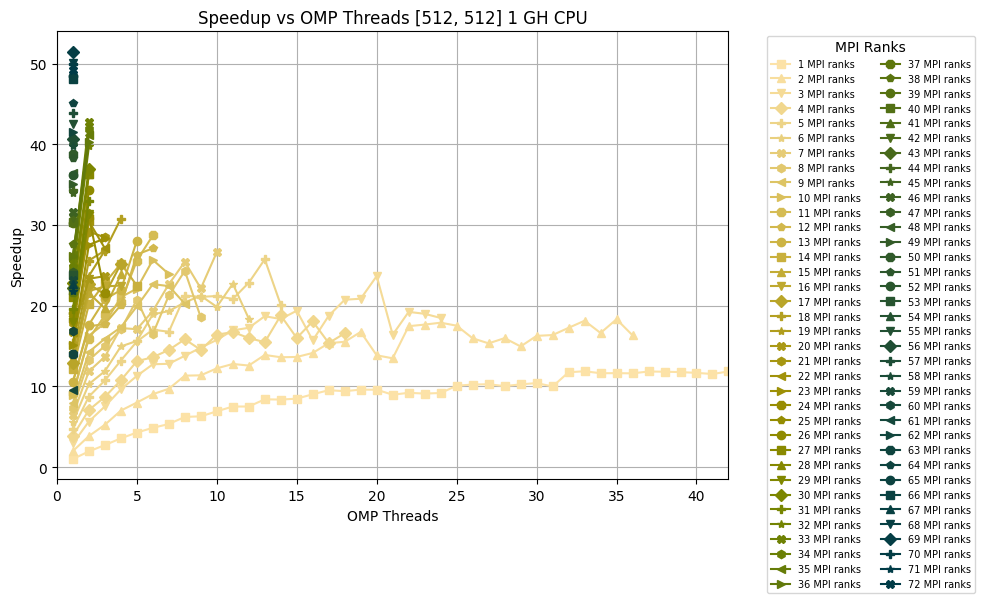

In [10]:

ranks = np.arange(1, 128, 1)
runtimes_array = np.array(runtimes)
nthreads = np.arange((runtimes_array.shape[0]))
nranks = np.arange(runtimes_array.shape[1])  # column indices = MPI ranks
plt.figure(figsize=(10, 6))

cmap = cm.bamako_r
colors = [cmap(i / (len(nranks) - 1)) for i in range(len(nranks))]
markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', 'h', '<', '>', '8', 'p']

for idx, j in enumerate(ranks):
    if j >= len(nranks):
        continue  # skip ranks out of bounds
    color = colors[j % len(colors)]
    runtimes_j = T_baseline / (runtimes_array[:, j])
    if np.any(runtimes_j > 0):
        marker = markers[j % len(markers)]  # Cycle through markers
        plt.plot(nthreads, runtimes_j, label=f"{j} MPI ranks", color=color, marker=marker)

plt.xlabel("OMP Threads")
plt.ylabel("Speedup")
plt.title(f"Speedup vs OMP Threads [{nx_len}, {ny_len}] 1 GH CPU")
plt.legend(title="MPI Ranks", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, ncol=2)
plt.grid(True)
plt.xlim(0, 42)
plt.tight_layout()
plt.savefig(f'./plots/Speedup_domain_graphs_{nx_len}_{ny_len}_1GHCPU', bbox_inches='tight', dpi=300)
plt.show()

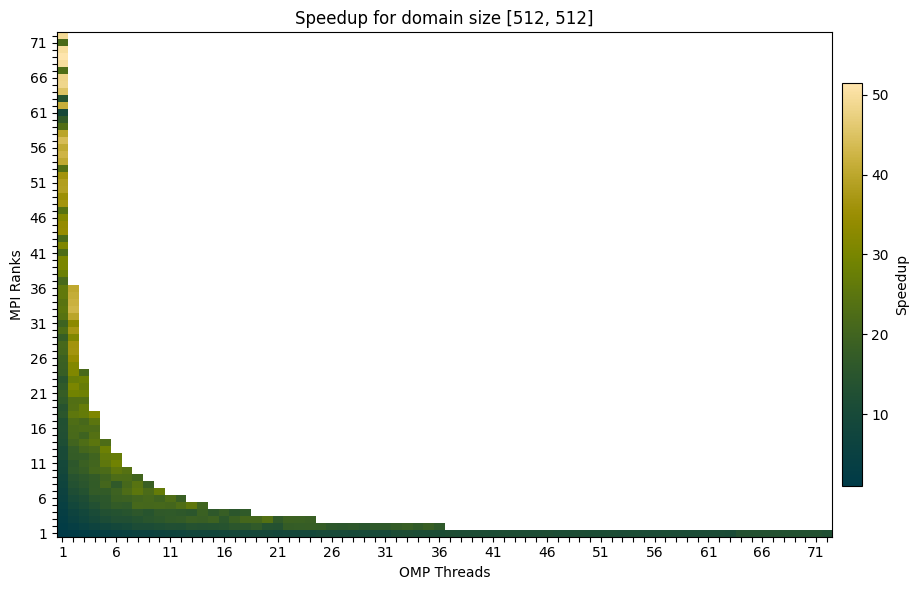

In [11]:
labels_array = np.array(labels)
nthreads = sorted(set(labels_array[:, 0]))
nranks = sorted(set(labels_array[:, 1]))

heatmap = np.full((len(nthreads), len(nranks)), np.nan)

for (t, r), val in zip(labels, speedups):
    i = nthreads.index(t)
    j = nranks.index(r)
    heatmap[i, j] = val
heatmap=heatmap.T

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.imshow(heatmap, cmap=cm.bamako, origin='lower', 
              vmin=1,
              # norm=LogNorm(vmin=np.nanmin(heatmap[heatmap > 0]), vmax=np.nanmax(heatmap)),
              aspect='auto'
              )


ax.set_ylabel('MPI Ranks')
ax.set_xlabel('OMP Threads')
ax.set_title(f'Speedup for domain size [{nx_len}, {ny_len}]')
fig.colorbar(c, label='Speedup', shrink=0.8, pad=0.01) 
ax.set_xticks(np.arange(len(nthreads)))
ax.set_xticklabels([str(x) if i % 5 == 0 else "" for i, x in enumerate(nthreads)])
ax.set_yticks(np.arange(len(nranks)))
ax.set_yticklabels([str(y) if i % 5 == 0 else "" for i, y in enumerate(nranks)])
plt.tight_layout()
plt.savefig(f'./plots/Speedup_domain_{nx_len}_{ny_len}_1GH_CPU', bbox_inches='tight', dpi=300)
plt.show()

In [49]:
from pathlib import Path
import re
import pandas as pd

# ========================= User configuration =========================
# Folder that contains the perf .txt files (change this to your folder)
DATA_DIR = Path('./perf/')   # e.g., Path("/path/to/perf/outputs")
FILE_GLOB = "*.txt"            # pattern of files to parse
OUTPUT_CSV = "perf_metrics_summary.csv"
# =====================================================================

# ------------------------- Helper functions ---------------------------
# NOTE: Regex patterns for extracting metrics from file content
METRIC_PATTERNS = {
    "mem_access_rd":      re.compile(r"([\d,]+)\s+mem_access_rd(?::[a-z])?\b", re.IGNORECASE),
    "mem_access_wr":      re.compile(r"([\d,]+)\s+mem_access_wr(?::[a-z])?\b", re.IGNORECASE),
    "LLC-load-misses":    re.compile(r"([\d,]+)\s+LLC-load-misses\b", re.IGNORECASE),
    "FP_SCALE_OPS_SPEC":  re.compile(r"([\d,]+)\s+FP_SCALE_OPS_SPEC\b", re.IGNORECASE),
    "FP_FIXED_OPS_SPEC":  re.compile(r"([\d,]+)\s+FP_FIXED_OPS_SPEC\b", re.IGNORECASE),
    "seconds time elapsed": re.compile(r"([\d.,]+)\s+seconds time elapsed\b", re.IGNORECASE),
}

def _to_number(s: str):
    """Convert a string with commas or decimals into int or float."""
    if s is None:
        return None
    s = s.replace(",", "")
    return float(s) if "." in s else int(s)

def parse_perf_file(path: Path) -> dict:
    """Parse one perf .txt file and return metrics as dict."""
    text = path.read_text(errors="ignore")
    result = {}
    for metric, pattern in METRIC_PATTERNS.items():
        m = pattern.search(text)
        value = _to_number(m.group(1)) if m else None
        result[metric] = value
    return result

def parse_filename_info(filename: str) -> dict:
    """
    Extract configuration info (OMP, MPI, nx, ny) from filename.
    Example: OMP12_MPI4_perf_x_nx512_ny512.txt
    """
    info = {}
    m = re.search(r"OMP(\d+)", filename, re.IGNORECASE)
    info["OMP"] = int(m.group(1)) if m else None
    
    m = re.search(r"MPI(\d+)", filename, re.IGNORECASE)
    info["MPI"] = int(m.group(1)) if m else None
    
    m = re.search(r"nx(\d+)", filename, re.IGNORECASE)
    info["nx"] = int(m.group(1)) if m else None
    
    m = re.search(r"ny(\d+)", filename, re.IGNORECASE)
    info["ny"] = int(m.group(1)) if m else None
    
    return info

# --------------------------- Main routine -----------------------------
files = sorted(DATA_DIR.glob(FILE_GLOB))
if not files:
    raise FileNotFoundError(f"No files matched {FILE_GLOB} in {DATA_DIR.resolve()}")

rows = []
index = []
for f in files:
    metrics = parse_perf_file(f)
    config = parse_filename_info(f.name)
    metrics.update(config)  # add OMP, MPI, nx, ny
    rows.append(metrics)
    index.append(f.stem)  # row name

df = pd.DataFrame(rows, index=index)

# Reorder columns to requested order + config info
ordered_cols = [
    "OMP", "MPI", "nx", "ny",
    "mem_access_rd",
    "mem_access_wr",
    "LLC-load-misses",
    "seconds time elapsed",
    "FP_SCALE_OPS_SPEC",
    "FP_FIXED_OPS_SPEC",
]
df = df.reindex(columns=ordered_cols)

# ---------------------- Derived metrics ----------------------
# Assumptions and notes:
#   * total_dram_accesses_per_core_in_Bytes = LLC-load-misses * 64 (bytes per cache line)
#   * total_mem_accesses_per_core_in_Bytes = (mem_access_rd + mem_access_wr) * 4 (bytes per access)
#   * flops = FP_SCALE_OPS_SPEC + FP_FIXED_OPS_SPEC
#   * runtime = seconds time elapsed
#   * Gbytes_moved = total_dram_accesses_per_core_in_Bytes * 72 / 1e9 (as requested)
#   * performance = flops / runtime
#   * intensity = flops / bytes_moved    (bytes_moved introduced below for convenience)

# Ensure numeric dtype for vectorized operations (keep NaN if missing)
for c in ["mem_access_rd", "mem_access_wr", "LLC-load-misses",
          "FP_SCALE_OPS_SPEC", "FP_FIXED_OPS_SPEC", "seconds time elapsed"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Base derived columns
df["total_dram_accesses_per_core_in_Bytes"] = df["LLC-load-misses"] * 64.0
df["total_mem_accesses_per_core_in_Bytes"] = (df["mem_access_rd"] + df["mem_access_wr"]) * 4.0
df["flops"] = df["FP_SCALE_OPS_SPEC"] + df["FP_FIXED_OPS_SPEC"]
df["runtime"] = df["seconds time elapsed"]

# Bytes moved (introduced to compute 'intensidad'); also compute GBytes as requested
df["bytes_moved"]  = df["total_dram_accesses_per_core_in_Bytes"] * 72.0

df["Gflops"] = df["flops"] / 1e9
df["Gbytes_moved"] = df["bytes_moved"] / 1e9

# Performance and intensity (avoid division by zero)
df["performance"] = np.where(df["runtime"] > 0, df["Gflops"] / df["runtime"], np.nan)
df["intensity"] = np.where(df["bytes_moved"] > 0, df["Gflops"] / df["Gbytes_moved"], np.nan)

# Move the derived columns to the end explicitly (already appended at end by creation order).
derived_cols = [
    "total_dram_accesses_per_core_in_Bytes",
    "total_mem_accesses_per_core_in_Bytes",
    "runtime",
    "Gflops",
    "Gbytes_moved",
    "performance",
    "intensity",
]
df = df[[*ordered_cols, *derived_cols]]

# Save and show
df.to_csv(OUTPUT_CSV, index=True)
display(df)
print(f"\nSaved matrix to: {OUTPUT_CSV}")
print(f"Parsed {len(files)} files from: {DATA_DIR.resolve()}")



,OMP,MPI,nx,ny,mem_access_rd,mem_access_wr,LLC-load-misses,seconds time elapsed,FP_SCALE_OPS_SPEC,FP_FIXED_OPS_SPEC,total_dram_accesses_per_core_in_Bytes,total_mem_accesses_per_core_in_Bytes,runtime,Gflops,Gbytes_moved,performance,intensity
OMP10_MPI10_perf_x_nx512_ny512,10,10,512,512,53889453777,9338135444,67727936,2.597881,674550356,206738169505,4.334588e+09,2.529104e+11,2.597881,207.412720,312.090329,79.839183,0.664592
OMP10_MPI10_perf_x_nx64_ny64,10,10,64,64,3238219875,232413314,20305527,0.117308,86660612,3276644554,1.299554e+09,1.388253e+10,0.117308,3.363305,93.567868,28.670813,0.035945
OMP10_MPI11_perf_x_nx512_ny512,10,11,512,512,53849045749,9338221731,66222720,2.638414,674529592,206743182993,4.238254e+09,2.527491e+11,2.638414,207.417713,305.154294,78.614551,0.679714
OMP10_MPI11_perf_x_nx64_ny64,10,11,64,64,3277007877,232400470,20825464,0.116557,86647288,3276370426,1.332830e+09,1.403763e+10,0.116557,3.363018,95.963738,28.852877,0.035045
OMP10_MPI12_perf_x_nx512_ny512,10,12,512,512,53813276518,9339254581,61015151,2.409266,674696760,206770312161,3.904970e+09,2.526101e+11,2.409266,207.445009,281.157816,86.102985,0.737824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OMP9_MPI7_perf_x_nx64_ny64,9,7,64,64,3045052630,232251329,19897382,0.121299,86652140,3276531438,1.273432e+09,1.310922e+10,0.121299,3.363184,91.687136,27.726410,0.036681
OMP9_MPI8_perf_x_nx512_ny512,9,8,512,512,53930074433,9337523370,81126749,2.986447,674477820,206725059431,5.192112e+09,2.530704e+11,2.986447,207.399537,373.832059,69.446919,0.554793
OMP9_MPI8_perf_x_nx64_ny64,9,8,64,64,2975832738,232202977,20779082,0.115943,86658972,3276531574,1.329861e+09,1.283214e+10,0.115943,3.363191,95.750010,29.007259,0.035125
OMP9_MPI9_perf_x_nx512_ny512,9,9,512,512,53930028796,9337638201,58717848,2.777941,674503120,206730786242,3.757942e+09,2.530707e+11,2.777941,207.405289,270.571844,74.661515,0.766544



Saved matrix to: perf_metrics_summary.csv
Parsed 490 files from: /users/class179/HPC4WC_proj5/perf


In [50]:
import matplotlib.pyplot as plt

AGG_CSV  = "group_stats_summary.csv"
PLOT_PNG = "roofline_santis.png"

# Santis CPU (Grace) ceilings — per node (adjust if needed)
N_GRACE_PER_NODE = 4               # number of Grace CPUs per node you want to model
BW_PER_GRACE_CPU = 512e9           # bytes/s per Grace CPU (LPDDR5X)
PEAK_FP64_PER_GRACE_CPU = 3.960576e12  # flop/s per Grace CPU (approx.)


# ------------------------- Group stats (nx, ny) -----------------------
agg = (df.groupby(["nx", "ny"], dropna=False)
         .agg(intensity_mean=("intensity", "mean"),
              intensity_min =("intensity", "min"),
              intensity_max =("intensity", "max"),
              perf_mean      =("performance", "mean"),
              perf_min       =("performance", "min"),
              perf_max       =("performance", "max"),
              n=("performance", "count"))
         .reset_index())

agg.to_csv(AGG_CSV, index=False)
print(f"Saved group stats -> {AGG_CSV}")


Saved group stats -> group_stats_summary.csv


In [68]:
xerr[0]

array([0.00371421, 0.2618463 ])

ValueError: 'xerr' (shape: (1, 2)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

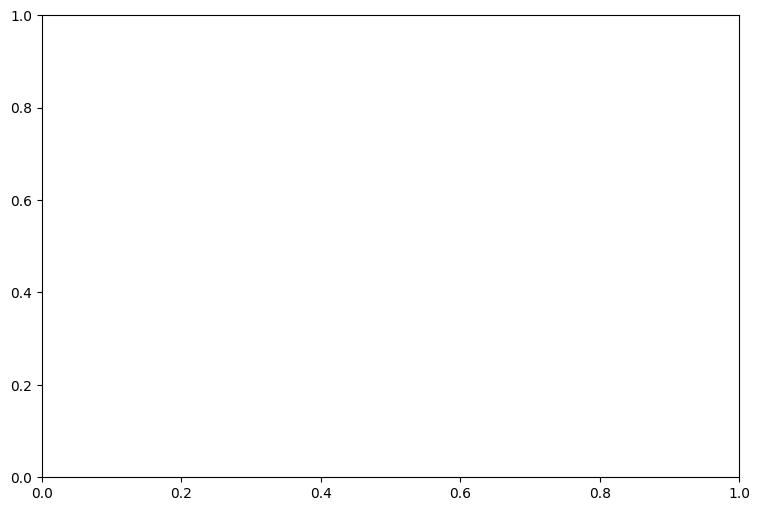

In [66]:
import matplotlib.pyplot as plt

# --------------------------- Roofline setup ---------------------------
B_CPU = BW_PER_GRACE_CPU              # bytes/s
P_CPU = PEAK_FP64_PER_GRACE_CPU       # flop/s
ridge_x = P_CPU / B_CPU               # FLOP/Byte at ridge

# x-range using observed intensities and ridge
obs_min = agg["intensity_min"].replace([np.inf, -np.inf], np.nan).min()
obs_max = agg["intensity_max"].replace([np.inf, -np.inf], np.nan).max()
if not np.isfinite(obs_min) or obs_min <= 0: obs_min = 1e-6
if not np.isfinite(obs_max) or obs_max <= 0: obs_max = 10.0

x_min = min(obs_min, ridge_x) * 0.5
x_max = max(obs_max, ridge_x) * 2.0
xs = np.logspace(np.log10(x_min), np.log10(x_max), 512)

# Roofline curve in GFLOP/s (divide by 1e9)
roof_cpu_gflops = np.minimum(P_CPU, B_CPU * xs) / 1e9
P_CPU_GF = P_CPU / 1e9  # GFLOP/s for legend

# ------------------------------- Plot --------------------------------
plt.figure(figsize=(9, 6))

# Convert grouped performance from FLOP/s to GFLOP/s for plotting
y_mean_gf = agg["perf_mean"].to_numpy()
y_min_gf  = agg["perf_min"].to_numpy()
y_max_gf  = agg["perf_max"].to_numpy()
yerr = np.vstack([y_mean_gf - y_min_gf, y_max_gf - y_mean_gf]).astype(float)
yerr = np.nan_to_num(yerr, nan=0.0, posinf=0.0, neginf=0.0)

# X remains intensity (FLOP/Byte); use asymmetric error bars
x = agg["intensity_mean"].to_numpy()
xerr = np.vstack([agg["intensity_mean"] - agg["intensity_min"],
                  agg["intensity_max"] - agg["intensity_mean"]]).astype(float)
xerr = np.nan_to_num(xerr, nan=0.0, posinf=0.0, neginf=0.0)
for i in lnop.arange(0, len(x)):
    plt.errorbar(x[o], y_mean_gf[o], xerr=xerr, yerr=yerr, fmt='o', capsize=3,
                 label="(nx, ny) means ± [min,max]")

# Roofline (CPU) in GFLOP/s
plt.plot(xs, roof_cpu_gflops, linewidth=1.5, color = "black",
         label=f"CPU roofline (per node)\nB≈{B_CPU/1e9:.2f} GB/s, P≈{P_CPU_GF:.2f} GFLOP/s")

# Ridge marker (x only; y value is roof at ridge)
plt.axvline(ridge_x, linestyle='--', linewidth=1, color = "red")
# Interpolate y for label
y_ridge = np.interp(ridge_x, xs, roof_cpu_gflops)
#plt.text(ridge_x, y_ridge, " ridge", rotation=90, va='bottom', ha='left')

# Axes, labels, style
plt.xscale('log', base=2); plt.yscale('log', base=2)
plt.xlabel("Operational intensity (FLOP / Byte)")
plt.ylabel("Performance (GFLOP/s)")
plt.title("Roofline Model — Santis")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()

plt.text(ridge_x-1.5, 2**5, 'memory bound', color='red', fontsize=12, rotation=90, va='bottom', ha='left')
plt.text(ridge_x+1.05, 2**5, 'compute bound', color='red', fontsize=12, rotation=90, va='bottom', ha='left')

plt.savefig(PLOT_PNG, dpi=200)
plt.show()

print(f"Saved roofline plot -> {PLOT_PNG}")
print(f"Ridge intensity ≈ {ridge_x:.3g} FLOP/Byte;  B≈{B_CPU/1e9:.2f} GB/s,  P≈{P_CPU_GF:.2f} GFLOP/s")